In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils.mobility_data_manager import DataManager

In [2]:
csv_file = "../Data/cityA_groundtruthdata.csv/cityA_groundtruthdata.csv"
manager = DataManager(
    csv_path=csv_file,
)
df = manager.load_csv()

print("Dataset creado:")

# Ver las dimensiones del DataFrame (filas y columnas)
print(f"Dimensiones del DataFrame: {df.shape}")

# Ver los nombres de las columnas y sus tipos de datos
print("\nInformación del DataFrame:")
display(df.info())  # display() para mejor presentación en notebooks

# Mostrar las primeras filas del DataFrame
print("\nPrimeras 5 filas del DataFrame:")
display(df.head(75))  # Mejor presentación en notebook

# Verificar si hay valores nulos por columna
print("\nValores nulos por columna:")
print(df.isnull().sum())

# Resumen estadístico de los datos numéricos
print("\nResumen estadístico:")
display(df.describe())

top_users = df["uid"].value_counts().head(10)
print("Usuarios más activos:\n", top_users)

Dataset creado:
Dimensiones del DataFrame: (111535175, 5)

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111535175 entries, 0 to 111535174
Data columns (total 5 columns):
 #   Column  Dtype
---  ------  -----
 0   uid     int64
 1   d       int64
 2   t       int64
 3   x       int64
 4   y       int64
dtypes: int64(5)
memory usage: 4.2 GB


None


Primeras 5 filas del DataFrame:


,uid,d,t,x,y
0,0,0,1,79,86
1,0,0,2,79,86
2,0,0,8,77,86
3,0,0,9,77,86
4,0,0,19,81,89
...,...,...,...,...,...
70,0,3,38,76,83
71,0,3,39,76,84
72,0,3,40,77,86
73,0,3,46,79,87



Valores nulos por columna:
uid    0
d      0
t      0
x      0
y      0
dtype: int64

Resumen estadístico:


,uid,d,t,x,y
count,1.115352e+08,1.115352e+08,1.115352e+08,1.115352e+08,1.115352e+08
mean,4.917461e+04,3.740868e+01,2.596529e+01,1.229079e+02,8.565036e+01
std,2.881183e+04,2.168145e+01,1.116733e+01,4.209912e+01,4.281913e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,2.393200e+04,1.900000e+01,1.800000e+01,9.500000e+01,5.800000e+01
50%,4.925800e+04,3.800000e+01,2.600000e+01,1.270000e+02,8.400000e+01
75%,7.392900e+04,5.700000e+01,3.500000e+01,1.550000e+02,1.110000e+02
max,9.999900e+04,7.400000e+01,4.700000e+01,2.000000e+02,2.000000e+02


Usuarios más activos:
 uid
62023    3497
63991    3456
62164    3431
63726    3367
2716     3358
2041     3335
56979    3333
963      3302
63484    3295
67216    3285
Name: count, dtype: int64


In [3]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

Dispositivo utilizado: cpu


In [6]:
# Filtrar solo las columnas necesarias
numerical_cols = ["d", "t", "x", "y"]
data = df[numerical_cols]


# Normalización de datos
scaler = MinMaxScaler()

data_scaled = scaler.fit_transform(data)

# Volver a DataFrame
df_scaled = pd.DataFrame(data_scaled, columns=numerical_cols)
df_scaled["uid"] = df["uid"]  # Agregar uid nuevamente

print("\nDatos normalizados:")
print(df_scaled.head())

# Obtener los parámetros del scaler para 'd'
d_min = scaler.data_min_[0]  # Valor mínimo original de 'd'
d_max = scaler.data_max_[0]  # Valor máximo original de 'd'
print(d_min, d_max)

# Normalizar los valores de días límite
train_day = (45 - d_min) / (d_max - d_min)
val_day = (60 - d_min) / (d_max - d_min)

print(f"Valor normalizado para día 45: {train_day:.4f}")
print(f"Valor normalizado para día 60: {val_day:.4f}")


# Dividir los datos normalizados
def split_data_normalized(df):
    train = df[df["d"] < train_day]
    val = df[(df["d"] >= train_day) & (df["d"] < val_day)]
    test = df[df["d"] >= val_day]
    return train, val, test

train_df, val_df, test_df = split_data_normalized(df_scaled)

print(f"\nDatos de entrenamiento: {len(train_df)} filas")
print(train_df)
print(f"Datos de validación: {len(val_df)} filas")
print(val_df)
print(f"Datos de prueba: {len(test_df)} filas")
print(test_df)


# 3. Crear Dataset y DataLoader
class MobilityDataset(Dataset):
    def __init__(self, df, seq_length=7):
        self.seq_length = seq_length
        self.data = df[["d", "t", "x", "y"]].values

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        X = self.data[idx : idx + self.seq_length]  # Entrada: secuencia de días
        y = self.data[idx + self.seq_length]  # Salida: día siguiente
        return torch.tensor(X, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )


# Secuencia de tamaño 7
seq_length = 7
batch_size = 1024

train_dataset = MobilityDataset(train_df, seq_length)
val_dataset = MobilityDataset(val_df, seq_length)
test_dataset = MobilityDataset(test_df, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDatasets preparados y cargados en DataLoaders.")


Datos normalizados:
     d         t        x         y  uid
0  0.0  0.021277  0.39196  0.427136    0
1  0.0  0.042553  0.39196  0.427136    0
2  0.0  0.170213  0.38191  0.427136    0
3  0.0  0.191489  0.38191  0.427136    0
4  0.0  0.404255  0.40201  0.442211    0
0.0 74.0
Valor normalizado para día 45: 0.6081
Valor normalizado para día 60: 0.8108

Datos de entrenamiento: 66088606 filas
                  d         t         x         y    uid
0          0.000000  0.021277  0.391960  0.427136      0
1          0.000000  0.042553  0.391960  0.427136      0
2          0.000000  0.170213  0.381910  0.427136      0
3          0.000000  0.191489  0.381910  0.427136      0
4          0.000000  0.404255  0.402010  0.442211      0
...             ...       ...       ...       ...    ...
111534993  0.364865  0.255319  0.618090  0.437186  99999
111534994  0.364865  0.276596  0.623116  0.462312  99999
111534995  0.364865  0.297872  0.592965  0.542714  99999
111534996  0.364865  0.319149  0.59296

In [7]:
class SimpleNN(nn.Module):
    def __init__(
        self, input_size=4, hidden_size=64, output_size=4, seq_length=7, num_layers=10
    ):
        super(SimpleNN, self).__init__()
        layers = [nn.Flatten()]  # Flatten para aplanar lo datos

        # Añadir las capas ocultas de forma dinámica
        for i in range(num_layers):
            if i == 0:  # Primera capa (de entrada a hidden)
                layers.append(nn.Linear(seq_length * input_size, hidden_size))
            else:  # Capas intermedias
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))  # Normalización
            layers.append(nn.LeakyReLU(0.01))  # Activación
            layers.append(nn.Dropout(0.3))  # Regularización

        # Última capa (de hidden a salida)
        layers.append(nn.Linear(hidden_size, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [8]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # entrenamineto
        model.train()
        train_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(
            f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

    return train_losses, val_losses

Epoch [1/30], Train Loss: 0.0262, Val Loss: 0.0348
Epoch [2/30], Train Loss: 0.0201, Val Loss: 0.0352
Epoch [3/30], Train Loss: 0.0189, Val Loss: 0.0380
Epoch [4/30], Train Loss: 0.0184, Val Loss: 0.0358
Epoch [5/30], Train Loss: 0.0182, Val Loss: 0.0364
Epoch [6/30], Train Loss: 0.0180, Val Loss: 0.0389
Epoch [7/30], Train Loss: 0.0179, Val Loss: 0.0379
Epoch [8/30], Train Loss: 0.0178, Val Loss: 0.0381
Epoch [9/30], Train Loss: 0.0177, Val Loss: 0.0393
Epoch [10/30], Train Loss: 0.0177, Val Loss: 0.0371
Epoch [11/30], Train Loss: 0.0176, Val Loss: 0.0386
Epoch [12/30], Train Loss: 0.0175, Val Loss: 0.0365
Epoch [13/30], Train Loss: 0.0175, Val Loss: 0.0364
Epoch [14/30], Train Loss: 0.0174, Val Loss: 0.0374
Epoch [15/30], Train Loss: 0.0174, Val Loss: 0.0382
Epoch [16/30], Train Loss: 0.0173, Val Loss: 0.0396
Epoch [17/30], Train Loss: 0.0173, Val Loss: 0.0374
Epoch [18/30], Train Loss: 0.0172, Val Loss: 0.0371
Epoch [19/30], Train Loss: 0.0172, Val Loss: 0.0376
Epoch [20/30], Train 

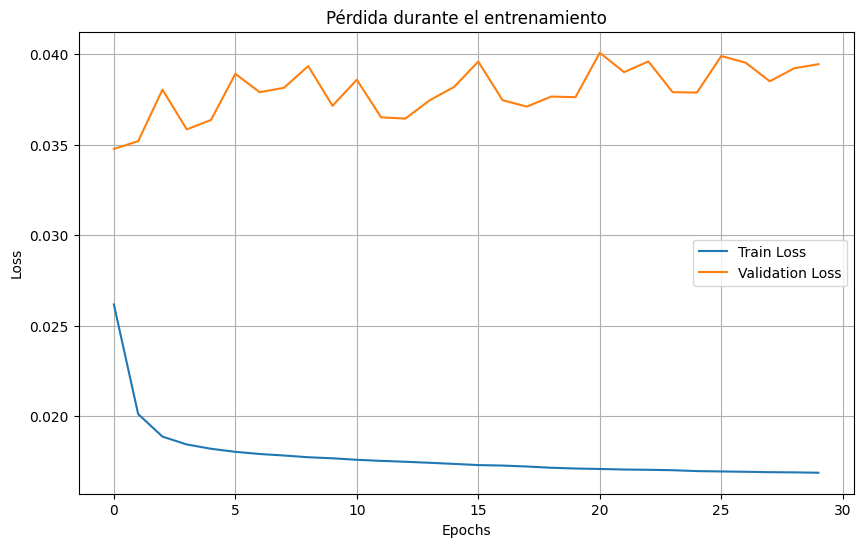

In [9]:
model = SimpleNN().to(device)
epochs = 2
train_losses, val_losses = train_model(
    model, train_loader, val_loader, epochs=epochs, lr=0.001
)

# 6. Gráficas de pérdida
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento")
plt.legend()
plt.grid()
plt.show()

In [10]:
torch.save(model, "../Data/Models/Simple_NN.pth")
print("Modelo completo guardado correctamente en 'simple_nn_complete.pth'.")

Modelo completo guardado correctamente en 'simple_nn_complete.pth'.


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

try:
    model = torch.load("../Data/Models/Simple_NN.pth")
except:
    model = model

model.eval()
test_losses = []
predictions, targets = [], []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        loss = nn.MSELoss()(outputs, y)
        test_losses.append(loss.item())
        outputs = scaler.inverse_transform(outputs)
        y = scaler.inverse_transform(y)
        predictions.extend(outputs)
        targets.extend(y)

# Convertir a numpy arrays para el cálculo de métricas
predictions = np.array(predictions)
targets = np.array(targets)

# Calcular errores (diferencia entre predicción y objetivo)
errors = predictions - targets
all_errors = np.sqrt(np.sum(errors**2, axis=1))  # Distancias euclidianas

# Estadísticas
global_mae = mean_absolute_error(targets, predictions)  # MAE
global_rmse = np.sqrt(mean_squared_error(targets, predictions))  # RMSE
error_max = np.max(all_errors)
error_min = np.min(all_errors)
error_median = np.median(all_errors)

# Imprimir resultados
print(f"Test Loss (MSE): {np.mean(test_losses):.4f}")
print(f"Error Medio Absoluto (MAE): {global_mae:.4f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {global_rmse:.4f}")
print(f"Error Máximo: {error_max:.4f}")
print(f"Error Mínimo: {error_min:.4f}")
print(f"Error Mediano: {error_median:.4f}")

print(f"\nTest Loss: {np.mean(test_losses):.4f}")

C:\Users\Brian_iq\AppData\Local\Temp\ipykernel_20356\1943125583.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("../Data/Models/Simple_NN.pth")


Test Loss (MSE): 0.0746
Error Medio Absoluto (MAE): 21.1922
Raíz del Error Cuadrático Medio (RMSE): 27.8095
Error Máximo: 183.2993
Error Mínimo: 27.3557
Error Mediano: 46.7737

Test Loss: 0.0746


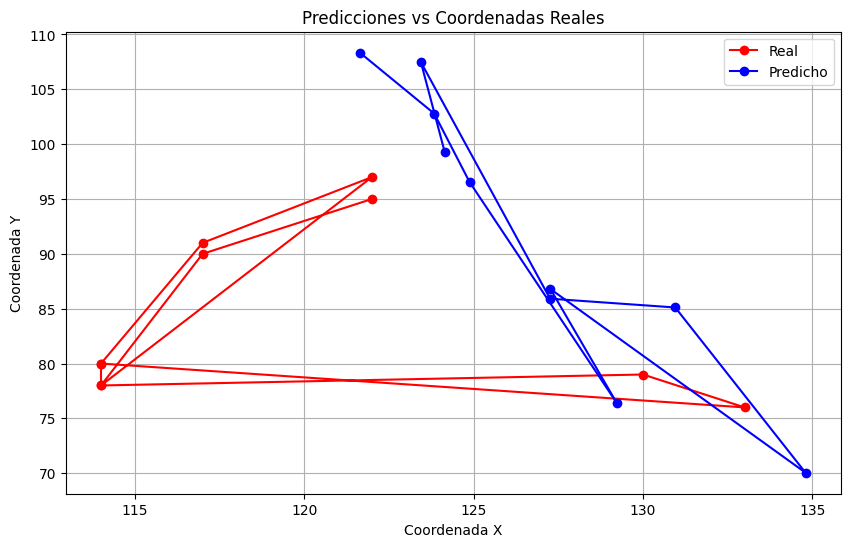

In [24]:
plt.figure(figsize=(10, 6))
step = 10
plt.plot(
    [t[2] for t in targets[:step]], [t[3] for t in targets[:step]], "ro-", label="Real"
)  # y reales
plt.plot(
    [p[2] for p in predictions[:step]],
    [p[3] for p in predictions[:step]],
    "bo-",
    label="Predicho",
)
# step = 10  # Dibuja cada 10 puntos
# plt.plot(
#     [t[2] for t in targets][::step],
#     [t[3] for t in targets][::step],
#     "ro-",
#     label="Real",
# )
# plt.plot(
#     [p[2] for p in predictions][::step],
#     [p[3] for p in predictions][::step],
#     "bo-",
#     label="Predicho",
# )
# demasiadas graficas
# plt.plot(
#     [t[2] for t in targets], [t[3] for t in targets], "ro-", label="Real"
# )  # y reales
# plt.plot(
#     [p[2] for p in predictions], [p[3] for p in predictions], "bo-", label="Predicho"
# )
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.title("Predicciones vs Coordenadas Reales")
plt.legend()
plt.grid()
plt.show()